In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *

from annotation_utilities import *

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.path import Path

import time

Setting environment for Gordon


In [20]:
username = 'yuncong'
stack = 'MD594'

In [21]:
label_polygons = load_label_polygons_if_exists(stack, username, force=True, annotation_rootdir=annotation_midbrainIncluded_rootdir)

Directory /oasis/projects/nsf/csd395/yuncong/CSHL_data_labelings_losslessAlignCropped_midbrainIncluded/MD594/0093/ does not exist.
Directory /oasis/projects/nsf/csd395/yuncong/CSHL_data_labelings_losslessAlignCropped_midbrainIncluded/MD594/0094/ does not exist.
Directory /oasis/projects/nsf/csd395/yuncong/CSHL_data_labelings_losslessAlignCropped_midbrainIncluded/MD594/0095/ does not exist.
Label GrC on Section 96 is not recognized.
Label VCA on Section 96 is not recognized.
Directory /oasis/projects/nsf/csd395/yuncong/CSHL_data_labelings_losslessAlignCropped_midbrainIncluded/MD594/0097/ does not exist.
Label GrC on Section 98 is not recognized.
Label VCA on Section 98 is not recognized.
Directory /oasis/projects/nsf/csd395/yuncong/CSHL_data_labelings_losslessAlignCropped_midbrainIncluded/MD594/0099/ does not exist.
Label VCA on Section 100 is not recognized.
Label GrC on Section 100 is not recognized.
Directory /oasis/projects/nsf/csd395/yuncong/CSHL_data_labelings_losslessAlignCropped

In [22]:
label_polygons_sideAssigned = assign_sideness(label_polygons)

In [23]:
downsample_factor = 16
xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [24]:
# interpolate contours

t = time.time()

interpolated_contours = [{} for _ in range(int(z_xy_ratio_downsampled*section_number_lookup[stack]))]
    
for name in label_polygons_sideAssigned.keys():
    
    considered_secs = label_polygons_sideAssigned[name].dropna().keys()
    
    n = len(considered_secs)
    
    for i in range(n):
        sec = considered_secs[i]            
        z0 = int(z_xy_ratio_downsampled*sec)
        interpolated_contours[z0][name] = label_polygons_sideAssigned.loc[sec][name]
        if i + 1 < n:
            next_sec = considered_secs[i+1]
            z1 = int(z_xy_ratio_downsampled*next_sec)
            interp_cnts = interpolate_contours(label_polygons_sideAssigned.loc[sec][name], 
                                               label_polygons_sideAssigned.loc[next_sec][name],
                                               z1-z0+1)
            for zi, z in enumerate(range(z0+1, z1)):
                interpolated_contours[z][name] = interp_cnts[zi+1]
                
sys.stderr.write('interpolate contours: %.2f seconds\n' % (time.time() - t)) # ~37s

interpolate contours: 29.50 seconds


In [25]:
t = time.time()

dm = DataManager(stack=stack)

img_height_downsampled = dm.image_height/downsample_factor
img_width_downsampled = dm.image_width/downsample_factor

volume = np.zeros((img_height_downsampled, img_width_downsampled, 
                   int(section_number_lookup[stack]*z_xy_ratio_downsampled)), np.int8)

print volume.shape

for z in range(volume.shape[2]):
        
    if len(interpolated_contours[z]) == 0:
        continue
    
    label_map_downsampled = np.zeros((img_height_downsampled, img_width_downsampled), np.int8)
    
    for name_s, vs in interpolated_contours[z].iteritems():
        vs_downsampled = vs/downsample_factor
        
        xmin, ymin = np.min(vs_downsampled, axis=0).astype(np.int)
        xmax, ymax = np.max(vs_downsampled, axis=0).astype(np.int)
                
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(xmax, img_width_downsampled-1)
        ymax = min(ymax, img_height_downsampled-1)
        
        xs, ys = np.meshgrid(range(xmin, xmax+1), range(ymin, ymax+1))
        points_to_test = np.c_[xs.flat, ys.flat]
                
        is_contained = Path(vs_downsampled).contains_points(points_to_test)
        label_map_downsampled[points_to_test[is_contained, 1], 
                              points_to_test[is_contained, 0]] = labels_sided_indices[name_s]
        
    volume[:, :, z] = label_map_downsampled.copy()
    
    del label_map_downsampled
    
sys.stderr.write('build volume all: %.2f seconds\n' % (time.time() - t)) # ~37s

(724, 1028, 1173)


build volume all: 32.46 seconds


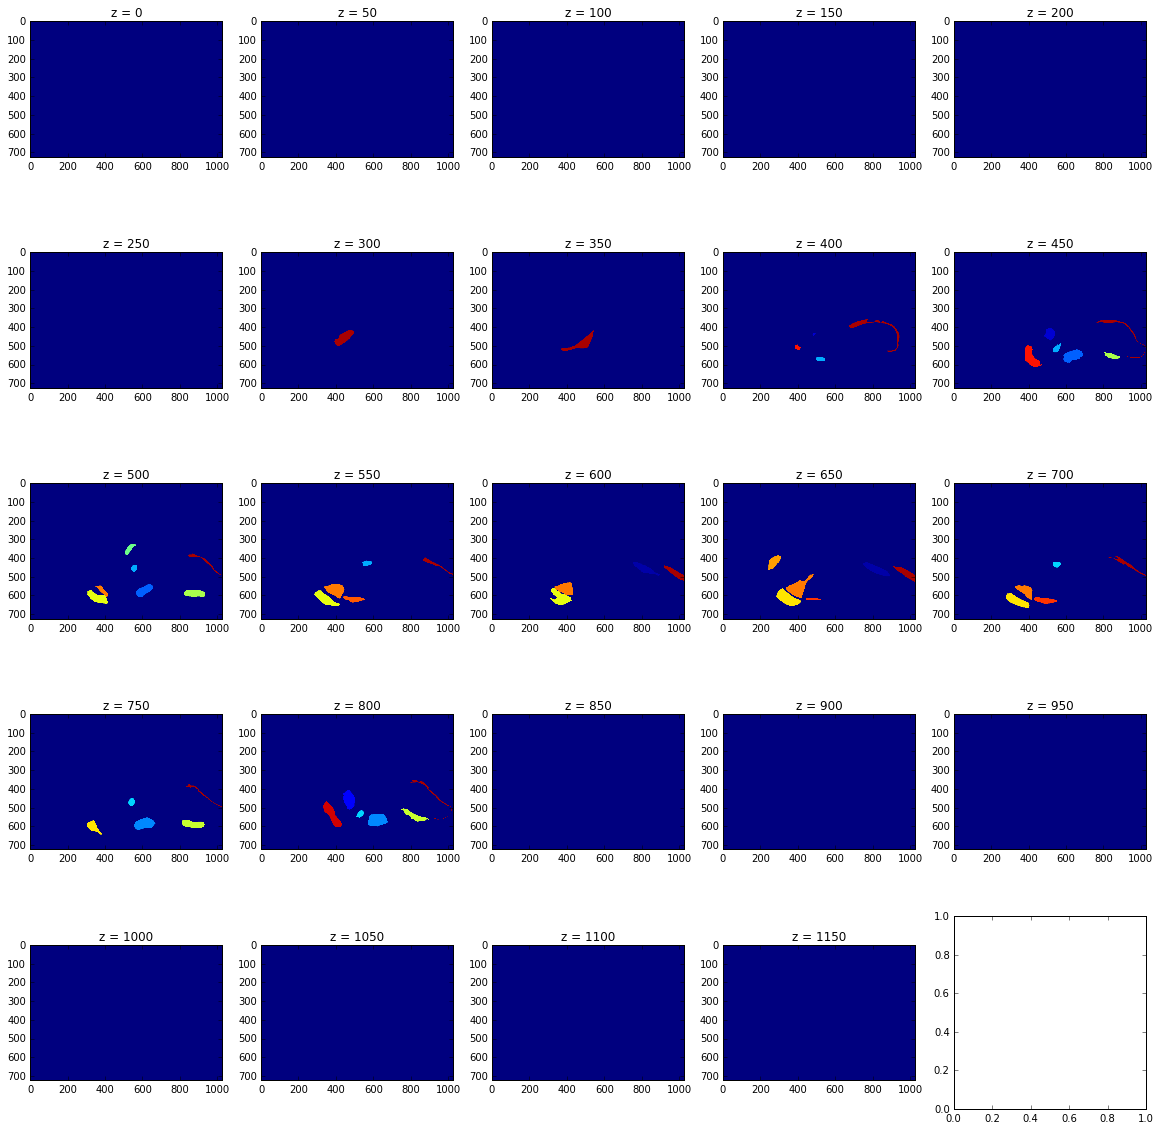

In [26]:
fig, axes = plt.subplots(5, 5, figsize=(20,20) , squeeze=True);
axes = axes.flatten()
for i, z in enumerate(range(0, volume.shape[2], 50)):
    axes[i].imshow(volume[..., z], vmin=0, vmax=len(labels_sided));
    axes[i].set_title('z = %d' % z);
plt.show();

In [27]:
xmin, xmax, ymin, ymax, zmin, zmax = bbox_3d(volume)

print 'volume bbox dimension:', xmin, xmax, ymin, ymax, zmin, zmax

reduced_xdim = xmax+1-xmin
reduced_ydim = ymax+1-ymin
reduced_zdim = zmax+1-zmin
print 'reduced bbox dimension:', reduced_xdim, reduced_ydim, reduced_zdim

volume bbox dimension: 233 1027 322 667 293 836
reduced bbox dimension: 795 346 544


In [28]:
reduced_volume = volume[ymin:ymax+1, xmin:xmax+1, zmin:zmax+1]

In [29]:
# output

bp.pack_ndarray_file(reduced_volume,
                     os.path.join(volume_dir, '%(stack)s/%(stack)s_annotationVolume.bp' % {'stack': stack}))

In [30]:
with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_annotationVolume_limits.txt' % {'stack': stack}), 'w') as f:
        f.write((' '.join(['%d']*6)+'\n') % (xmin, xmax, ymin, ymax, zmin, zmax))
        
with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_annotationVolume_resolution.txt' % {'stack': stack}), 'w') as f:
        f.write((' '.join(['%f']*3)+'\n') % (downsample_factor, xy_pixel_distance_downsampled, z_xy_ratio_downsampled))

In [31]:
with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_annotationVolume_landmarkBboxes.txt' % {'stack': stack}), 'w') as f:
    for name in label_polygons_sideAssigned.keys():
        bbox = bbox_3d(reduced_volume == labels_sided_indices[name])
        f.write(name + ' ' + ' '.join(map(str, bbox)) + '\n')

In [32]:
with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_annotationVolume_labelIndices.txt' % {'stack': stack}), 'w') as f:
    f.write('BackG 0\n')
    for name_s in label_polygons_sideAssigned.keys():
        f.write(name_s + ' ' + str(labels_sided_indices[name_s]) + '\n')